# Modelo Regresión Logística: Encuesta Reddit Chile

## Conexión a fuente de datos

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

In [4]:
df.head()

,edad,religion,sexo_Hombre,sexo_Mujer,orientacion_Bisexual,orientacion_Heterosexual,orientacion_Homosexual,ocupacion_Estudio,ocupacion_Ninguna,ocupacion_Trabajo,...,deporte_4horas,perro_agua,perro_atom_humber,perro_bus,perro_chilaquil,perro_ladron,perro_lipigas,perro_matapacos,perro_washington,perro_waton
0,27,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,30,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,18,1,1,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,19,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Selección de variables predictoras y de respuesta.

In [5]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [7]:
# datos de entrenamiento antes de balance 
y_train.value_counts()

1    517
0    419
Name: politica_izquierda, dtype: int64

In [8]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_NQ = y_train_NQ.sample(len(y_train_Q), replace = True, 
                               random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

In [9]:
# datos de entrenamiento despueés de balanceo
y_train.value_counts()

1    517
0    517
Name: politica_izquierda, dtype: int64

# Modelo Base

In [10]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

In [11]:
# usaremos regresión logística como base:
from sklearn.tree import DecisionTreeClassifier

modelo_base = DecisionTreeClassifier(ccp_alpha=0.001, 
                                     criterion='entropy', 
                                     max_depth=6,
                                     max_features='sqrt', 
                                     min_samples_leaf=0.01,
                                     min_samples_split=0.3, 
                                     random_state=42)
modelo_base.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=6,
                       max_features='sqrt', min_samples_leaf=0.01,
                       min_samples_split=0.3, random_state=42)

# Cross-Validation y ajuste

In [12]:
# importar clasificador por bagging
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(base_estimator = modelo_base, # Modelo base
                            n_estimators = 100,
                            random_state = 42,
                            n_jobs = cores)

## CV

In [13]:
from sklearn.model_selection import cross_validate

cv_bagging = cross_validate(bagging,
                            X_train, 
                            y_train,   
                            cv = 5,
                            verbose = 3)

cv_bagging

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.662 total time=   2.5s
[CV] END ......................................., score=0.618 total time=   0.0s
[CV] END ......................................., score=0.623 total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] END ......................................., score=0.657 total time=   0.0s
[CV] END ......................................., score=0.626 total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


{'fit_time': array([2.61737919, 0.04276872, 0.04189134, 0.04289198, 0.04587507]),
 'score_time': array([0.03236651, 0.03019667, 0.03153944, 0.03192258, 0.03091288]),
 'test_score': array([0.66183575, 0.61835749, 0.62318841, 0.65700483, 0.62621359])}

## Ajuste

In [14]:
modelo_bagging = bagging.fit(X_train, y_train)

# Resultados modelo

## Métricas

In [15]:
y_pred_train = modelo_bagging.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"], 
                            index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en data de entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en data de entrenamiento:
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       517
           1       0.71      0.57      0.63       517

    accuracy                           0.67      1034
   macro avg       0.68      0.67      0.67      1034
weighted avg       0.68      0.67      0.67      1034



In [16]:
y_pred_test = modelo_bagging.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"], 
                           index = y_test.index)

print("Resultado en data de prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en data de prueba:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       117
           1       0.69      0.56      0.62       117

    accuracy                           0.65       234
   macro avg       0.66      0.65      0.65       234
weighted avg       0.66      0.65      0.65       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 69% de las veces.  
**Recall**: El modelo es capaz de identificar el 56% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 65% de las veces.

## Curva ROC & AUC

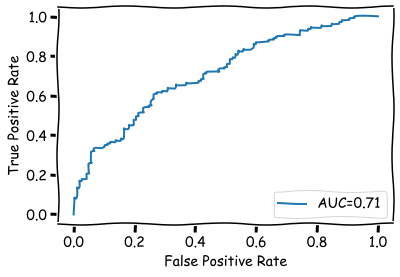

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo_bagging.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## PR

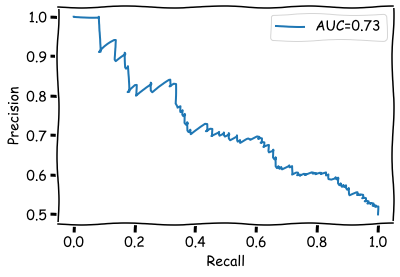

In [20]:
with plt.xkcd():
    pr = metrics.precision_recall_curve(y_test, y_prob_test)
    auc_pr = round(metrics.average_precision_score(y_test, y_prob_test), 2)
    plt.plot(pr[1], pr[0], label="AUC="+str(auc_pr))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc=1)
    plt.show()